## Advanced Automation - Project Abalone (Group 1) - Neural Networks

Margarida Gralha (100222),
Tiago Neves (100272),
Rodrigo Amorim (100702)

## Import all libraries

In [1]:
import sklearn
import matplotlib.pyplot as plt
import graphviz
import matplotlib as mpl
import seaborn as sns
import scipy
import os
import pandas as pd
import numpy as np
from pickle import dump
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from tensorflow.keras.models import Model
from keras.regularizers import l2

## Data processing

In [2]:
## LOAD DATASET

abl_df = pd.read_csv(os.path.abspath('abalone_data.csv'))
abl_df.head()

,Sex,Length (mm),Diameter (mm),Height (mm),Whole weight (g),Shucked weight (g),Viscera weight (g),Shell weight (g),Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
## ADD CATEGORICAL COLUMN FOR INFANT (BASED ON PREVIOUS RESULT)

dummies = pd.get_dummies(abl_df,columns = ['Sex'],dtype=int)
X = abl_df.drop(columns = ['Sex','Rings']).astype('float64')
X = pd.concat([X, dummies[['Sex_I']]], axis=1)

y = abl_df['Rings']

In [4]:
## SPLIT THE DATA INTO TRAINING (70%), VALIDATION (20%) AND TEST (10%) SETS

seed = 1

X_rest, X_test, y_rest, y_test = train_test_split(X.values, y.values.reshape(-1,1), train_size=0.9, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, train_size = 0.889, random_state=seed)

# Defining number of features for posterior neural network execution
n_features = X_train.shape[1]

In [5]:
## NORMALIZE THE INPUTS AND OUTPUTS

# Create the transformer from the input matrix
scaler_X = StandardScaler(with_mean=True,with_std=True).fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Create the transformer from the output vector
scaler_y = StandardScaler(with_mean=True,with_std=True).fit(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

## Grid search

In [7]:
## HYPERPARAMETERS: regularization parameter, activation, dropout and learning rate

# Neural network model setup
def create_model(lr, activation, neurons, dropout, hidden_layers, reg_param):
    
    # Create model
    model = Sequential()
    
    # Add the first hidden layer with Ridge regularization (L2)
    model.add(Dense(neurons, input_dim=8, activation=activation, kernel_regularizer=l2(reg_param)))
    model.add(Dropout(dropout))
    
    # Add the remaining hidden layers with Ridge regularization (L2)
    if hidden_layers > 1:
        for i in range(hidden_layers - 1):
            model.add(Dense(neurons-50, activation=activation, kernel_regularizer=l2(reg_param)))
            model.add(Dropout(dropout))
    
    # Add the output layer
    model.add(Dense(1, activation='linear'))
    
    # Compile model
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    
    return model

# Create model
model = KerasRegressor(build_fn=create_model, verbose=0,
                       hidden_layers=1, neurons=100,
                       batch_size=32, epochs=100)

# Define the grid search parameters
param_grid = [{'reg_param': [0.01, 0.1], 'activation': ['relu', 'linear'], 'dropout': [0.15, 0.2], 'lr': [1e-4, 1e-3]}]

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val))

# Summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = -grid_result.cv_results_['mean_test_score']  # Convert back to positive for MSE
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\tiago\AppData\Local\Temp\ipykernel_55848\1521263677.py:29: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0,


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best: 4.475875 using {'activation': 'relu', 'dropout': 0.2, 'lr': 0.001, 'reg_param': 0.01}
5.457188 (0.886062) with: {'activation': 'relu', 'dropout': 0.15, 'lr': 0.0001, 'reg_param': 0.01}
5.363100 (0.774494) with: {'activation': 'relu', 'dropout': 0.15, 'lr': 0.0001, 'reg_param': 0.1}
4.480717 (0.303361) with: {'activation': 'relu', 'dropout': 0.15, 'lr': 0.001, 'reg_param': 0.01}
4.690491 (0.365228) with: {'activation': 'relu', 'dropout': 0.15, 'lr': 0.001, 'reg_param': 0.1}
5.456806 (0.952799) with: {'activation': 'relu', 'dropout': 0.2, 'lr': 0.0001, 'reg_param': 0.01}
5.359549 (0.795153) with: {'activation': 'relu', 'dropout': 0.2, 'lr': 0.0001, 'reg_param': 0.1}
4.475875 (0.294420) with: {'activation': 'relu', 'dropout': 0.2, 'lr': 0.001, 'reg_param': 0.01}
4.689943 (0.408530) with: {'activation': 'relu', 'dropout': 0.2, 'lr': 0.001, 'reg_param': 0.1}
5.025037 (0.371347) with: {'activation': 'linear', 'dropout': 0.15,

In [8]:
## HYPERPARAMETERS: regularization parameter, dropout and learning rate

# Neural network model setup
def create_model(lr, activation, neurons, dropout, hidden_layers, reg_param):
    
    # Create model
    model = Sequential()
    
    # Add the first hidden layer with Ridge regularization (L2)
    model.add(Dense(neurons, input_dim=8, activation=activation, kernel_regularizer=l2(reg_param)))
    model.add(Dropout(dropout))
    
    # Add the remaining hidden layers with Ridge regularization (L2)
    if hidden_layers > 1:
        for i in range(hidden_layers - 1):
            model.add(Dense(neurons-50, activation=activation, kernel_regularizer=l2(reg_param)))
            model.add(Dropout(dropout))
    
    # Add the output layer
    model.add(Dense(1, activation='linear'))
    
    # Compile model
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    
    return model

# Create model
model = KerasRegressor(build_fn=create_model, verbose=0,
                       hidden_layers=1, neurons=100,
                       batch_size=32, epochs=100, activation='relu')

# Define the grid search parameters
param_grid = [{'reg_param': [0.001, 0.005, 0.01], 'dropout': [0.15, 0.2, 0.25], 'lr': [0.0001, 0.0005, 0.001]}]

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val))

# Summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = -grid_result.cv_results_['mean_test_score']  # Convert back to positive for MSE
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\tiago\AppData\Local\Temp\ipykernel_55848\3057895640.py:29: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0,


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best: 4.393738 using {'dropout': 0.2, 'lr': 0.001, 'reg_param': 0.001}
5.540667 (1.112557) with: {'dropout': 0.15, 'lr': 0.0001, 'reg_param': 0.001}
5.530884 (1.065688) with: {'dropout': 0.15, 'lr': 0.0001, 'reg_param': 0.005}
5.572347 (1.236336) with: {'dropout': 0.15, 'lr': 0.0001, 'reg_param': 0.01}
4.533793 (0.318477) with: {'dropout': 0.15, 'lr': 0.0005, 'reg_param': 0.001}
4.582350 (0.377586) with: {'dropout': 0.15, 'lr': 0.0005, 'reg_param': 0.005}
4.667836 (0.381487) with: {'dropout': 0.15, 'lr': 0.0005, 'reg_param': 0.01}
4.469138 (0.295017) with: {'dropout': 0.15, 'lr': 0.001, 'reg_param': 0.001}
4.423280 (0.271168) with: {'dropout': 0.15, 'lr': 0.001, 'reg_param': 0.005}
4.491633 (0.348605) with: {'dropout': 0.15, 'lr': 0.001, 'reg_param': 0.01}
5.655467 (1.184938) with: {'dropout': 0.2, 'lr': 0.0001, 'reg_param': 0.001}
5.467509 (0.967557) with: {'dropout': 0.2, 'lr': 0.0001, 'reg_param': 0.005}
5.627998 (1.16764

In [6]:
## HYPERPARAMETERS: 1st hidden layer neurons, 2nd hidden layer neurons, batch size

# Neural network model setup
def create_model(lr, activation, neurons1, neurons2, dropout, hidden_layers, reg_param):

    # Create model
    model = Sequential()

    # Add the first hidden layer with Ridge regularization (L2)
    model.add(Dense(neurons1, input_dim=8, activation=activation, kernel_regularizer=l2(reg_param)))
    model.add(Dropout(dropout))

    # Add the remaining hidden layers with Ridge regularization (L2)
    if hidden_layers > 1:
        for i in range(hidden_layers - 1):
            model.add(Dense(neurons2, activation=activation, kernel_regularizer=l2(reg_param)))
            model.add(Dropout(dropout))

    # Add the output layer
    model.add(Dense(1, activation='linear'))

    # Compile model
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

    return model

# Create model
model = KerasRegressor(build_fn=create_model, verbose=0,
                       hidden_layers=1, dropout=0.15, reg_param = 0.005,
                       lr=0.001, epochs=100, activation='relu')

# Define the grid search parameters
param_grid = [{'neurons1': [100, 150, 200], 'neurons2': [25, 50, 100], 'batch_size': [32, 64]}]

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val))

# Summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = -grid_result.cv_results_['mean_test_score']  # Convert back to positive for MSE
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\tiago\AppData\Local\Temp\ipykernel_55848\925949547.py:29: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0,


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best: 4.388203 using {'batch_size': 32, 'neurons1': 200, 'neurons2': 100}
4.438555 (0.260053) with: {'batch_size': 32, 'neurons1': 100, 'neurons2': 25}
4.498361 (0.316924) with: {'batch_size': 32, 'neurons1': 100, 'neurons2': 50}
4.421043 (0.254815) with: {'batch_size': 32, 'neurons1': 100, 'neurons2': 100}
4.463953 (0.286294) with: {'batch_size': 32, 'neurons1': 150, 'neurons2': 25}
4.431744 (0.277556) with: {'batch_size': 32, 'neurons1': 150, 'neurons2': 50}
4.444123 (0.302324) with: {'batch_size': 32, 'neurons1': 150, 'neurons2': 100}
4.392076 (0.267521) with: {'batch_size': 32, 'neurons1': 200, 'neurons2': 25}
4.398183 (0.235228) with: {'batch_size': 32, 'neurons1': 200, 'neurons2': 50}
4.388203 (0.235529) with: {'batch_size': 32, 'neurons1': 200, 'neurons2': 100}
4.607709 (0.407183) with: {'batch_size': 64, 'neurons1': 100, 'neurons2': 25}
4.626445 (0.392827) with: {'batch_size': 64, 'neurons1': 100, 'neurons2': 50}
4.60

## Neural network execution (with regularization)

In [12]:
## TRYING DIFFERENT PARAMETERS FOR THE NEURAL NETWORK STRUCTURE
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Define the neural network model (activation, dropout and regularization parameter are based on grid search results)
def create_model(n_features, layer1_units, layer2_units, learning_rate):
    model = Sequential()
    model.add(Dense(layer1_units, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.005), input_shape=(n_features,)))
    model.add(Dropout(0.2))
    model.add(Dense(layer2_units, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.005)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation=None))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    return model

# Function to predict
def predict_model(model, X_test):
    return model.predict(X_test, verbose=0)

# Parameters to choose [First hidden layer, second hidden layer, learning rate, epochs, batch size]
params = [[100, 50, 1e-4, 500, 64],
          [100, 50, 1e-3, 500, 32],
          [150, 25, 1e-4, 500, 64],
          [200, 100, 1e-3, 500, 32]]

# Writing results and organizing them for posterior plotting
results_df = pd.DataFrame(columns=['resid', 'x_axis', 'label'])
losses_df = pd.DataFrame(columns=['epoch', 'loss', 'val_loss', 'label'])
mse_original_df = pd.DataFrame(columns=['mse_original', 'label'])
for i, param in enumerate(params):
    print(f'Iteration {i+1}/{len(params)}')
    
    model = create_model(n_features, param[0], param[1], param[2])
    history = model.fit(X_train_scaled, y_train_scaled, epochs=param[3], batch_size=param[4], verbose=0, validation_data=(X_val_scaled, y_val_scaled))
    
    yhat = predict_model(model, X_test_scaled)
    resid = scaler_y.inverse_transform(yhat) - y_test
    mse_original = metrics.mean_squared_error(scaler_y.inverse_transform(yhat),y_test)
    x_axis = y_test
    
    results_df = pd.concat([results_df, pd.DataFrame({'resid': resid.reshape(-1,), 'x_axis': x_axis.reshape(-1,), 'label': ','.join(map(str, param))})])
    losses_df = pd.concat([losses_df, pd.DataFrame({'epoch': [(i // 10) * 10 for i in history.epoch], 'loss': history.history['loss'], 'val_loss': history.history['val_loss'], 'label': ','.join(map(str, param))})])
    mse_original_df = pd.concat([mse_original_df, pd.DataFrame({'mse_original': mse_original.reshape(-1,), 'label': ','.join(map(str, param))})])

Iteration 1/4
Iteration 2/4
Iteration 3/4
Iteration 4/4


In [33]:
mse_original_df['mse_original'].iloc[0]

3.9374316235385587

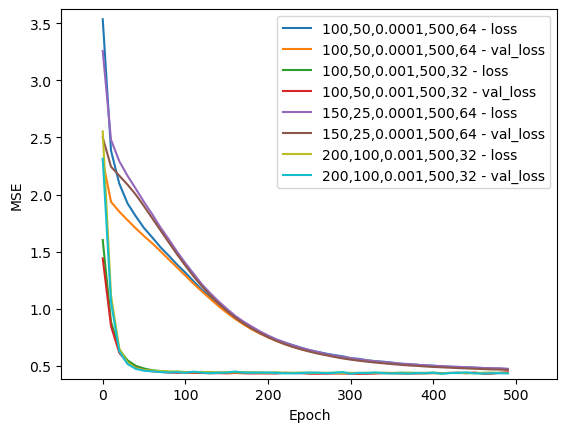

In [17]:
## VISUALIZING MSEs OF PREVIOUS RESULTS

# Organizing results for MSE (on the normalized scale) plotting
losses = losses_df.groupby(['epoch', 'label']).mean().reset_index().sort_values(by = ['label', 'epoch'])
losses = pd.melt(losses, id_vars = ['epoch', 'label'], value_vars = ['loss', 'val_loss'], var_name = 'test')
losses['label'] = losses['label'] + ' - ' + losses['test']
losses = losses.sort_values(by = ['label', 'epoch'])
labels = losses.label.unique()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
         'tab:purple', 'tab:brown', 'tab:olive', 'tab:cyan']

# Plotting each MSE curve for each neural network model
fig, ax = plt.subplots()
for i in range(len(labels)):
    idxs = losses.label == labels[i]
    ax.plot(losses[idxs].epoch, losses[idxs].value, c=colors[i], label=labels[i])
ax.legend()
ax.grid(False)
ax.set_xlim([-50, 550])
ax.set_ylim([losses.value.min()*0.9, losses.value.max()*1.025])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
plt.show()

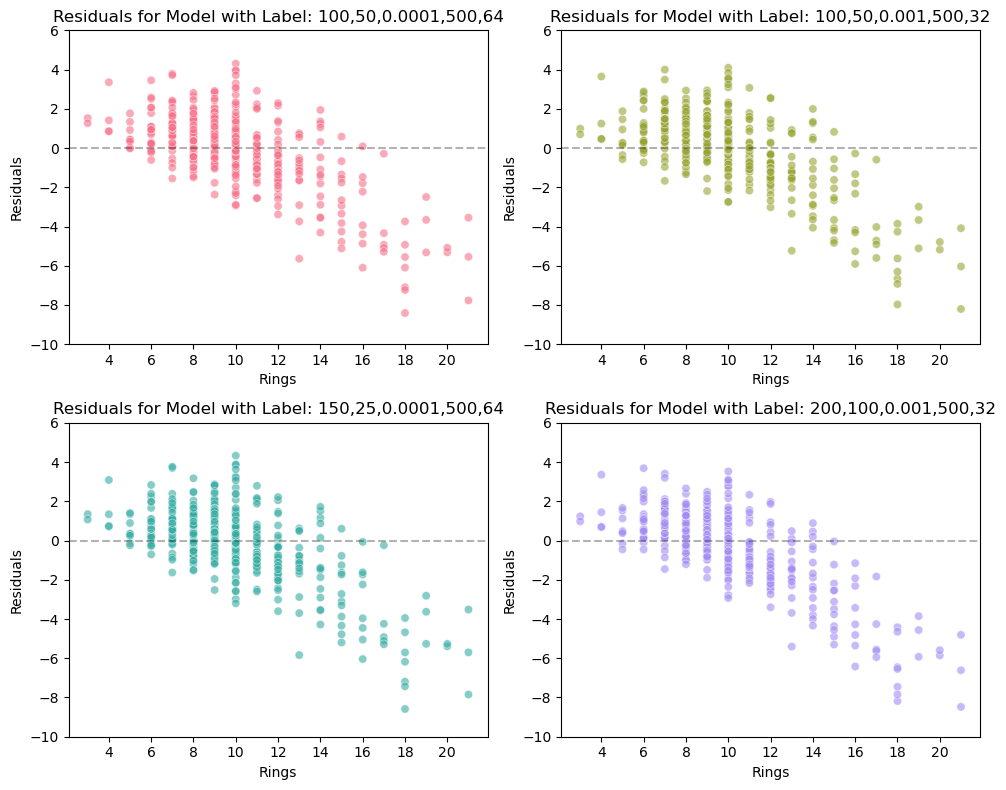

Test MSE on original scale for each model
Model with Label 100,50,0.0001,500,64: 3.9374
Model with Label 100,50,0.001,500,32: 3.8739
Model with Label 150,25,0.0001,500,64: 3.9739
Model with Label 200,100,0.001,500,32: 4.1738


In [34]:
from matplotlib.ticker import MultipleLocator

## VISUALIZING RESIDUALS OF PREVIOUS RESULTS

# Labels for each neural network model
labels = ['100,50,0.0001,500,64',
          '100,50,0.001,500,32',
          '150,25,0.0001,500,64',
          '200,100,0.001,500,32']

# Set color for each model
colors = sns.color_palette('husl', n_colors=len(labels))

# 2x2 grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Indexing matters
axes = axes.flatten()

# Plotting each model residuals
for i in range(len(labels)):
    results_df_i = results_df[results_df['label'] == labels[i]]
    sns.scatterplot(data=results_df_i, x='x_axis', y='resid', hue='label', palette=[colors[i]], alpha=0.6, ax=axes[i])
    axes[i].axhline(y=0, linestyle='--', color='black', label='y=0', alpha=0.3)
    axes[i].set_xlabel('Rings')
    axes[i].set_ylabel('Residuals')
    axes[i].set_title(f'Residuals for Model with Label: {labels[i]}')
    axes[i].legend().set_visible(False)
    axes[i].set_ylim([-10, 6])
    axes[i].xaxis.set_major_locator(MultipleLocator(2))

# Adjusting display
plt.tight_layout()
plt.show()

# Test MSE (on the original scale) of all models
print('Test MSE on original scale for each model')
for i in range(len(labels)):
    print('Model with Label {}: {:.4f}'.format(labels[i], mse_original_df['mse_original'].iloc[i]))

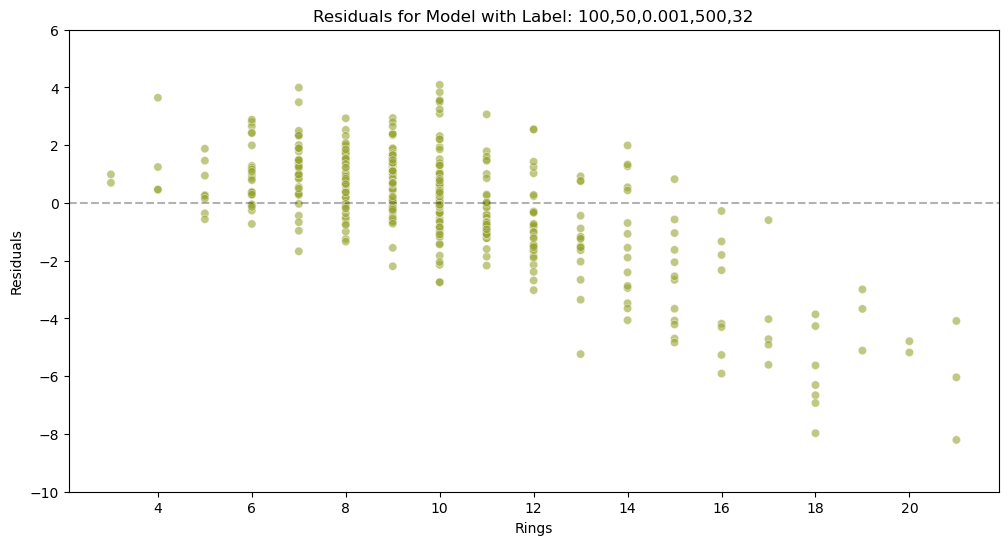

In [47]:
# Label of the specific model you want to plot
specific_label = '100,50,0.001,500,32'

# Filtering the DataFrame for the specific model
specific_results_df = results_df[results_df['label'] == specific_label]

# Plotting residuals for the specific model
plt.figure(figsize=(12, 6))
sns.scatterplot(data=specific_results_df, x='x_axis', y='resid', hue='label', palette=[colors[1]], alpha=0.6)
plt.axhline(y=0, linestyle='--', color='black', label='y=0', alpha=0.3)
plt.xlabel('Rings')
plt.ylabel('Residuals')
plt.title(f'Residuals for Model with Label: {specific_label}')
plt.ylim([-10, 6])
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
plt.legend().set_visible(False)

# Display the plot
plt.show()